# Week 4 - Probability Distributions 3 and Mixture Models

Learning contents:

1. Histogram-based density estimation
    - Display histogram densities
2. Kernel density estimation
    - Hypercube Kernel function
    - Gaussian Kernel function
3. K-Nearest Neigbours classification
    - Generate data
    - Classification function
    - Display results
4. K-Means clustering
    - Display results

## Dependencies

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from math import sqrt
from collections import Counter
from scipy.stats import norm
from sklearn import datasets
from IPython.display import HTML
from math import floor

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate data

write a function `generate_data_1D` that returns `n` number of 1D random variables exhibiting mixture of Gaussian distribution with parameters `means`, `variances` and `pi`.

In [32]:
def generate_data_1D(size, means, variances, pi):
    x=[]
    np.random.seed(10)
    for i in range(size):
        z_i = np.argmax(np.random.multinomial(1, pi))
        x_i = np.random.normal(means[z_i], variances[z_i]) 
        x.append(x_i) 
    return x

The function below generates 1000 data points from the Gaussian mixture distribution and plots their histogram. Observe the plot and comment on whether the plot coincides with the input data.

(array([0.03759899, 0.0150396 , 0.0075198 , 0.0150396 , 0.03759899,
        0.03007919, 0.02255939, 0.03759899, 0.06767818, 0.04511879,
        0.14287615, 0.08271777, 0.10527717, 0.10527717, 0.15791575,
        0.21055433, 0.22559393, 0.14287615, 0.21055433, 0.10527717,
        0.15791575, 0.16543555, 0.12783656, 0.11279696, 0.13535636,
        0.06767818, 0.06767818, 0.06767818, 0.03007919, 0.03759899,
        0.05263858, 0.05263858, 0.03759899, 0.04511879, 0.03007919,
        0.03007919, 0.05263858, 0.04511879, 0.03007919, 0.0150396 ,
        0.05263858, 0.0150396 , 0.05263858, 0.04511879, 0.07519798,
        0.06767818, 0.09775737, 0.09775737, 0.07519798, 0.09775737,
        0.04511879, 0.06767818, 0.06767818, 0.04511879, 0.03759899,
        0.07519798, 0.06767818, 0.04511879, 0.0075198 , 0.02255939,
        0.0075198 , 0.0075198 , 0.04511879, 0.02255939, 0.06015838,
        0.06767818, 0.06767818, 0.06767818, 0.06015838, 0.10527717,
        0.11279696, 0.11279696, 0.13535636, 0.09

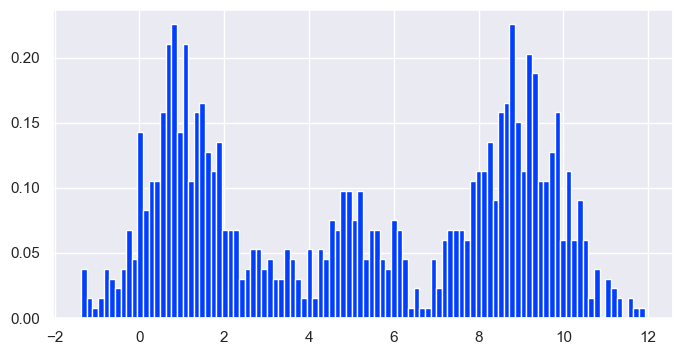

In [33]:
means = [1, 5, 9]
variances = [1, 1, 1]
pis = [0.4, 0.2, 0.4]
data = generate_data_1D(1000, means, variances, pis)
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(data, bins=100, density=True)


## 1) Histogram-based density estimation

write a function `histogram` that takes input `data`, user-defined bin size `delta` and returns `bins` (list of edges of the bins) and their corresponding `probabilities`. Hint: you can use numpy's histogram function to do so.

In [34]:
def histogram(data, delta):
    dataRange = np.max(data) - np.min(data)
    bins = int(dataRange/delta) # Delta = size of bins, max - min = range,   range / size of each = amount of bins
    probability, bins = np.histogram(a = data, bins = bins, density=True) # Density set to True to make it normalized.
    return (bins, probability) # Numpy returns the opposite of what's desired in the code box

### 1.1) Display histogram densities

Display the `histograms` for different values of bin sizes and also compute and plot the `true` probability density (slide 9 of lecture 7) of the data. Compare the two plots and see which values of bin sizes reveal densities that are close to the true density function

In [35]:
def univariate_normal(x, mean, variance):
    return ((1. / np.sqrt(2 * np.pi * variance)) * np.exp(-(x - mean)**2 / (2 * variance)))

def display_histogram_density(data, delta):
    bins, probs = histogram(data, delta)

    a = np.arange(-5, 15, 0.01)
    yi = lambda i: pis[i] * univariate_normal(a, mean = means[i], variance = variances[i])
    y = yi(0) + yi(1) + yi(2) # Same function as given, just rewritten                          y = pis[0] * univariate_normal(a, mean=means[0], variance=variances[0]**2) + pis[1] * univariate_normal(a, mean=means[1], variance=variances[1]**2)+ pis[2] * univariate_normal(a, mean=means[2], variance=variances[2]**2)
    fig, ax = plt.subplots(figsize=(8, 4))
    print(np.sum(probs * np.diff(bins))) # == 1?? => Normalized
    ax.bar(bins[:-1],probs,width=0.1)
    ax.plot(a, y,'-r')

1.0000000000000002


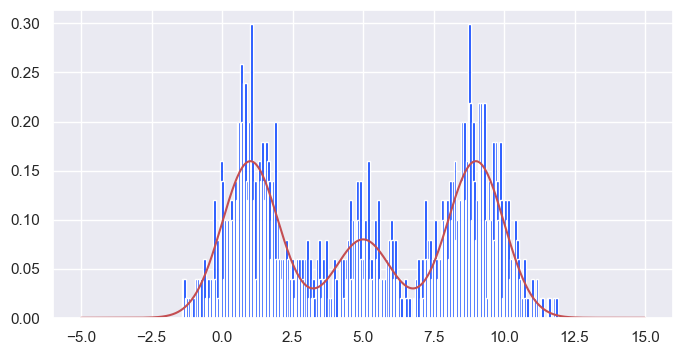

In [36]:
display_histogram_density(data, 0.05)

1.0


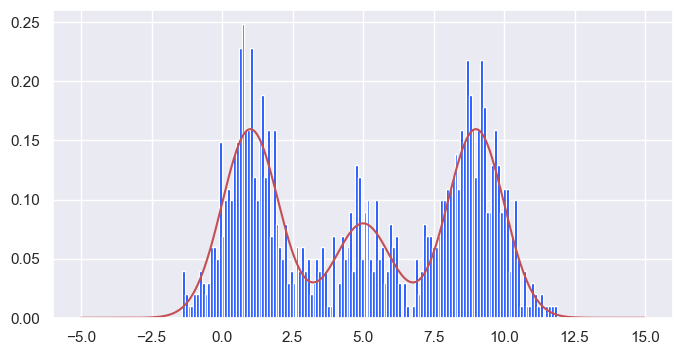

In [37]:
display_histogram_density(data, 0.1)

1.0


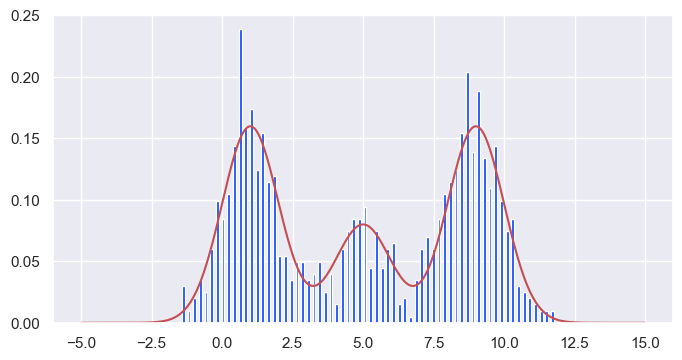

In [38]:
display_histogram_density(data, 0.2)

1.0


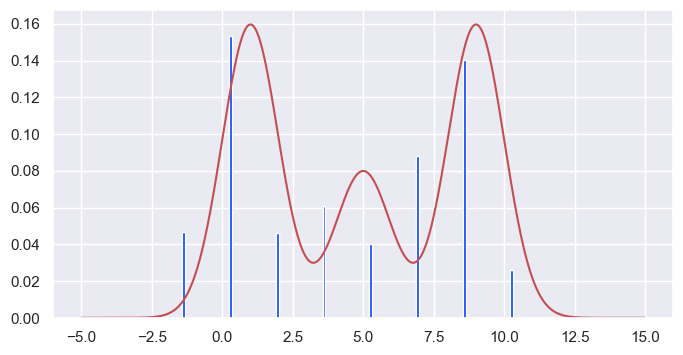

In [39]:
display_histogram_density(data, 1.5)

## 2) Kernel density estimation

### 2.1) Hypercube Kernel function

write a function `hypercube_kernel_function` takes `u` and returns 0 or 1 if `u` is inside 1/2 hypercube (see slide 18 of lecture 7).

In [40]:
def hypercube_kernel_function(u):
    return  1 if np.abs(u) < 1/2        else 0 

write the function `hypercube_kernel_density` that takes a single data point `x`, training data points `data`, size of a cube `h`, data dimensions `D` and returns the probability density of `x` based on the Hypercube kernel function (see the first equation on slide 19 of lecture 7)

In [41]:
def hypercube_kernel_density(x, data, h, D):
    N = len(data)
    p = 1/N * np.sum([1/(h**D) * hypercube_kernel_function((x - data[n])/h) for n in range(1, N)])
    return p 

display the computed nonparametric density estimates for different values of `h`. What is the effect of `h` on density estimates?

In [42]:
def display_hypercube_kernel_density_1D(data, h, color='b'):
    xs = np.linspace(min(data), max(data), 200)
    plt.plot(xs, list(map(lambda x: hypercube_kernel_density(x, data, h, 1), xs)), '-' + color, label='h=' + str(h))
    plt.legend()


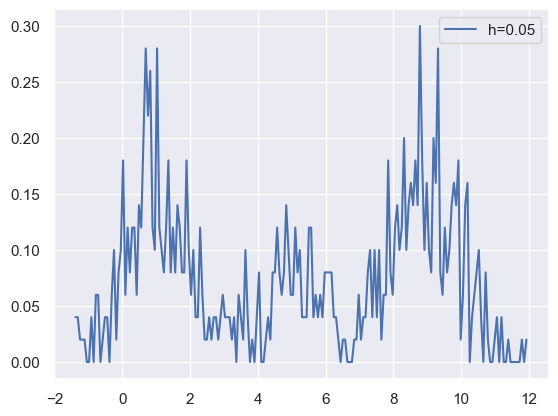

In [43]:
display_hypercube_kernel_density_1D(data, 0.05, 'b')

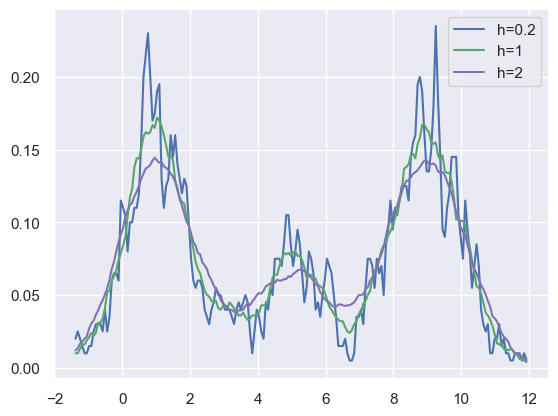

In [44]:
display_hypercube_kernel_density_1D(data, 0.2, 'b')
display_hypercube_kernel_density_1D(data, 1, 'g')
display_hypercube_kernel_density_1D(data, 2, 'm')

### 2.2) Gaussian Kernel function

Write the function `gaussian_kernel_function` that takes pair of points `x` and `x_n`, size `h` and returns Gaussian kernel function value for the pair of points.

In [45]:
def gaussian_kernel_function(x, x_n, h): # Reading the describition as this is the i'th of summation. 
    dist = np.abs((x - x_n)**2)                
    return (1/( h * np.sqrt(2 * np.pi))) * np.exp(-dist/(2*(h**2))) 
                                         # Rewriting √(2πh^2) as √h^2 * √(2π) = h√(2π)

Write the `gaussian_kernel_density` function that takes any point `x`, training data points `data`, size `h` and returns the Gaussian kernel density value for the point `x` (see the last equation in slide 19 of lecture 7)

In [46]:
def gaussian_kernel_density(x, data, h):
    N = len(data)
    p = (1/N) * np.sum(np.array([gaussian_kernel_function(x, data[n], h) for n in range(0, N)]))
    return p

In [47]:
def display_gaussian_kernel_density_1D(data, h, color='b'):
    xs = np.linspace(min(data), max(data), 200)
    plt.plot(xs, list(map(lambda x: gaussian_kernel_density(x, data, h), xs)), '-' + color, label='h=' + str(h))
    plt.legend()

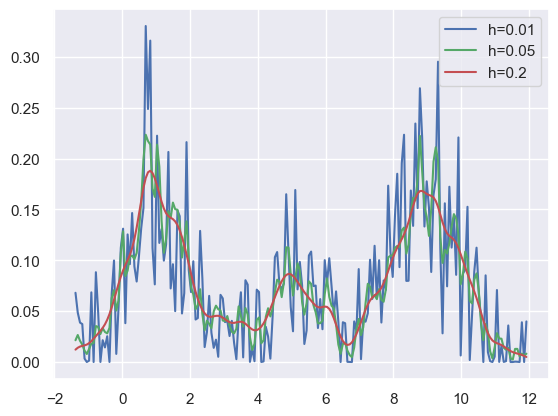

In [48]:
display_gaussian_kernel_density_1D(data, 0.01, 'b')
display_gaussian_kernel_density_1D(data, 0.05, 'g')
display_gaussian_kernel_density_1D(data, 0.2, 'r')

## 3) K-Nearest Neigbours classification

### 3.1) Generate Data

Using IRIS dataset from the sklearn library. Note that the data is 2-dimensional (two features). Plot the data.

(<matplotlib.collections.PathCollection at 0x1392e7b90>,
 <matplotlib.legend.Legend at 0x1392e5040>)

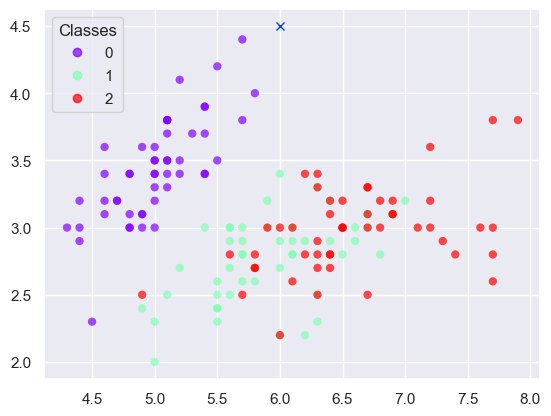

In [49]:
iris = datasets.load_iris()
iris_x = np.array(iris.data[:, :2])  # we only take the first two features.
iris_t = np.array(iris.target)

def plot_iris(legend=True, classes=iris_t, target=plt):
    target.plot([6.0], [4.5], 'x')
    scatter = target.scatter(iris_x[:, 0], iris_x[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    
    return (scatter, )


plot_iris()

### 3.2) Classification function

write the `k_nearest_classification` function that takes a test data point `x`, training data points `data_x` and their associated classes `data_t`, the neighbours `k` and returns the predicted class for the test point `x`

In [50]:
from collections import Counter
def k_nearest_classification(x, data_x, data_t, k):             #    k = 2 - x looking for it's nearest k neighbors in training data                   
    distxy = data_x - x                                         #          r              b
    dist = np.linalg.norm(distxy, axis=1)                       #               r__           b
    indicies = np.argsort(dist)[:k]                             #           g      \_x           g   
    # for i in range(0, k):                                     #           r     g/       r 
        # print(f"For i = {indicies[i]}, er distancen = {dist[indicies[i]]}")  r            b
                                                                #               g                  g   
    classes_predicted = data_t[indicies]
    # Now which is of the predicted classes is most likely to be the one? Either the majority or the first index in a draw. 
    class_pre_count = Counter(classes_predicted).most_common(1) # This module has the right behavior. 
    #                                                           When in majority 1 winner, when in draw 1 winner, the first element
    class_predicted = class_pre_count[0][0]
    return class_predicted
                                  
x = np.array([6.0, 4.5])
k_nearest_classification(x, iris_x[:, 0:2], iris_t, 2)


np.int64(0)

### 3.3) Display results

Display the classification results for different values of `K`

In [51]:
def plot_mesh(pred_fn, n_class=3, x_min=4, x_max=8, y_min=2, y_max=4.5, target=plt):
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = np.array(list(map(lambda x: pred_fn(np.array(x)), np.c_[xx.ravel(), yy.ravel()])))
    Z = Z.reshape(xx.shape)
    cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))
    target.axis('tight')
    if hasattr(target, 'xlim'):
        target.xlim(x_min, x_max)
        target.ylim(y_min, y_max)

/var/folders/s1/8pjch1gd44lcppl6nnk77kdh0000gn/T/ipykernel_40420/3786169586.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


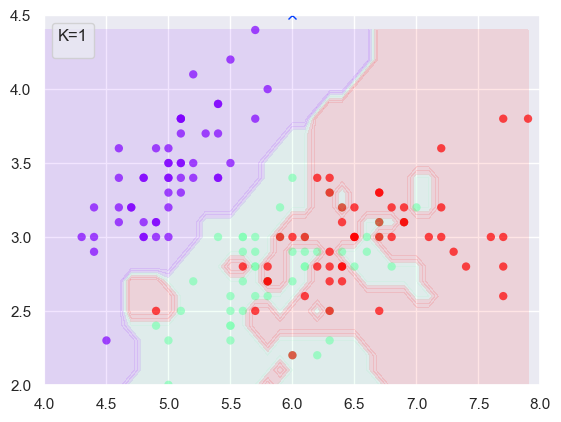

In [52]:
plot_iris(False)
plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 1))
# plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 1))
plt.legend([], loc="upper left", title="K=1")

/var/folders/s1/8pjch1gd44lcppl6nnk77kdh0000gn/T/ipykernel_40420/3786169586.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


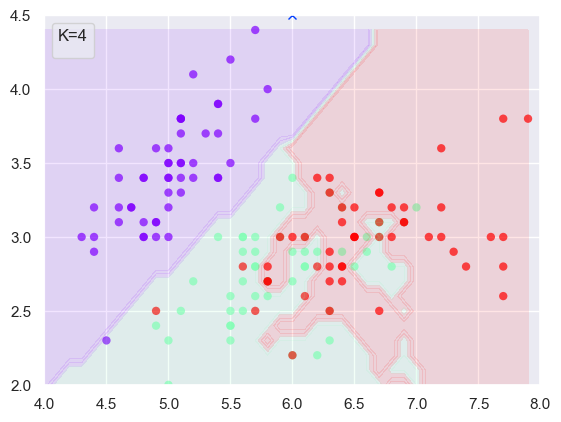

In [53]:
plot_iris(False)
plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 4))
plt.legend([], loc="upper left", title="K=4")

/var/folders/s1/8pjch1gd44lcppl6nnk77kdh0000gn/T/ipykernel_40420/3786169586.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


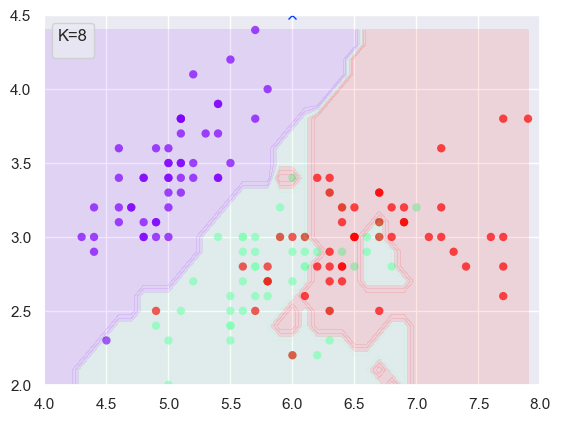

In [54]:
plot_iris(False)
plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 8))
plt.legend([], loc="upper left", title="K=8")

## 4) K-Means clustering

write the `k_means_step` function that takes initial means vector `mus_0`, input data points `data_x` and returns the new means `mus` and the corresponding `classes` after running a single iteration of the K-means algorithm

In [55]:
def k_means_step(mus_0, data_x):
    K = mus_0.shape[0]
    distances = np.linalg.norm(data_x[:, np.newaxis] - mus_0, axis=2)  # Shape (N, K).   N = data points, K = amounts of centroids.
    classes = np.argmin(distances, axis=1)                             # Shaping every data point into its nearest cluster. 
    
    # If xn in k then boolean true, else boolean false. 
    rnk = lambda k : classes == k 
    mus = np.array([data_x[rnk(k)].mean(axis=0) for k in range(K)])
    # print(mus)
    return mus, classes
    


mus_0 = np.array([[4, 4.5], [6, 2], [7, 2]])
k_means_step(mus_0, iris_x)

(array([[4.97777778, 3.525     ],
        [5.78333333, 2.84761905],
        [7.05      , 3.08333333]]),
 array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2,
        1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2,
        1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1]))

the following function, `distortion_measure`, takes means `mus`, `classes`, data points `data_x` and returns distortion of this classification (see slide 8 of lecture 8)

In [56]:
def distortion_measure(mus, classes, data_x):
    
    result = 0
    
    for i, c in enumerate(classes):
        
        x = data_x[i]
        mu = mus[c]
        distance = np.dot(np.array(mu) - np.array(x), np.array(mu) - np.array(x))
        result += distance
    
    return result

`optimize_k_means` takes initial means `mus_0`, data points `data_x` and callback `on_step`. `on_step` is a function that takes current `mus` and `classes` and should be called each step. The function will be used later to apply multiple steps of the k-means algorithm to converge on the `true` mean and corresponding classes.

In [57]:
def optimize_k_means(mus_0, data_x, on_step):
    new_mus, classes = k_means_step(mus_0, data_x)
    on_step(new_mus, classes)

### 4.1) Display results

In [58]:
def plot_k_means(mus, classes, target=plt):
    plot = plot_iris(classes=classes, target=target)
    scatter = target.scatter(mus[:, 0], mus[:, 1], c=[0, 1, 2], cmap='rainbow', marker='X', s=300, edgecolors='black')
    return (*plot, scatter)

In [59]:
k = 3
mus_0 = iris_x[:k]

all_steps = []

optimize_k_means(mus_0, iris_x, lambda mus, classes: all_steps.append((mus, classes)))
print(all_steps)

[(array([[6.17840909, 3.26022727],
       [5.57346939, 2.65306122],
       [4.59230769, 3.20769231]]), array([0, 1, 2, 2, 0, 0, 2, 0, 2, 1, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 2, 1, 0, 0, 0, 2, 2, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 1, 2, 0,
       0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]))]


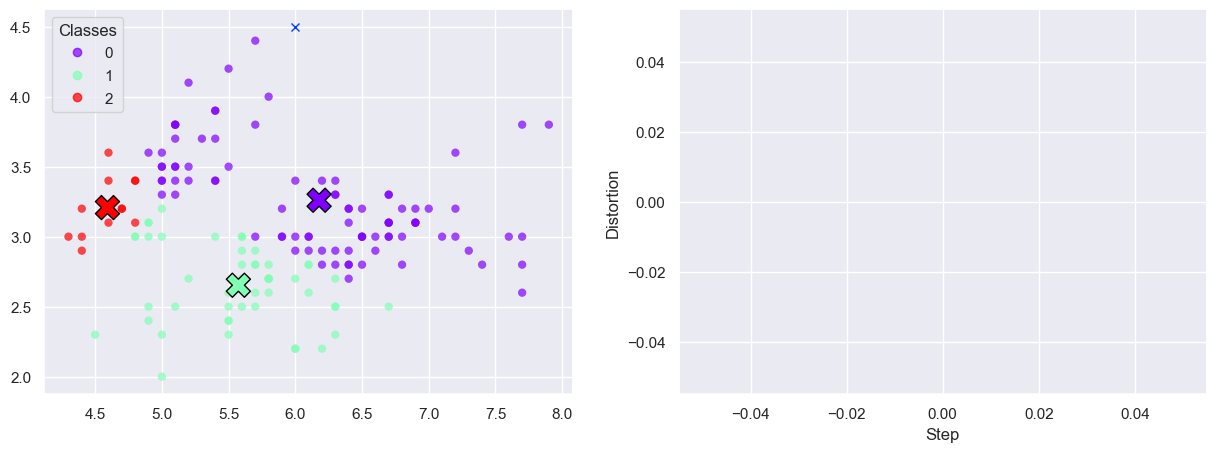

In [60]:
def create_animation(all_steps, data_x):
    
    distortions = list(map(
        lambda a: distortion_measure(a[0], a[1], data_x),
        all_steps
    ))
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        plot1 = plot_k_means(all_steps[i][0], all_steps[i][1], target=ax)
        ax2.plot(list(range(i)), distortions[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Distortion')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

create_animation(all_steps, iris_x)